In [45]:
import os

import json
import numpy as np


from langchain_community.vectorstores import FAISS
import faiss
import torch
# from tqdm import tqdm


from transformers import AutoTokenizer, AutoModel
from langchain_core.prompts import ChatPromptTemplate, FewShotChatMessagePromptTemplate

# from abc import abstractmethod
# import concurrent.futures
# from concurrent.futures import ThreadPoolExecutor
from langchain_openai import ChatOpenAI
from langchain import hub
from dotenv import load_dotenv
from langchain_core.documents import Document
from typing_extensions import List, TypedDict

from sentence_transformers import SentenceTransformer


In [54]:
"""Normally User-Inputted Args"""
dataset = 'musique'
model_label = 'SBERT'
unit = 'hippo'

vector_path = f'data/{dataset}/{dataset}_{model_label}_{unit}_vectors_norm.npy'
index_path = f'data/{dataset}/{dataset}_{model_label}_{unit}_ip_norm.index'

#check if index has been built, otherwise build it using Sentence BERT
if(os.path.isfile(index_path)):
    if dataset == 'musique':
        faiss_index = faiss.read_index('data/musique/musique_facebook_contriever_proposition_ip_norm.index')
    else:
        faiss_index = faiss.read_index('data/2wikimultihopqa/2wikimultihopqa_facebook_contriever_proposition_ip_norm.index')
else:
    corpus_contents = []
    if dataset == 'musique':
        corpus = json.load(open('data/musique_corpus.json', 'r'))
    elif dataset == '2wikimultihopqa':
        corpus = json.load(open('data/2wikimultihopqa_corpus.json', 'r'))
    for item in corpus:
        corpus_contents.append(item['title'] + '\n' + item['text'])
    model = SentenceTransformer('bert-base-nli-mean-tokens')
    sentence_embeddings = model.encode(corpus_contents)
    d = sentence_embeddings.shape[1] #dimension
    nlist = 50  # how many cells
    quantizer = faiss.IndexFlatL2(d)
    index = faiss.IndexIVFFlat(quantizer, d, nlist)
    index.train(sentence_embeddings)
    print(f'status of index training: {index.is_trained}')
    index.add(sentence_embeddings)
    print(f'number of embeddings indexed: {index.ntotal}')
    index.nprobe = 10
    fp = open(index_path, 'w')
    faiss.write_index(index, index_path)
    print('index saved to {}'.format(index_path))
    print('index size: {}'.format(index.ntotal))

In [69]:
#sanity check
k = 8
# xq = model.encode(["When was the person who Messi's goals in Copa del Rey compared to get signed by Barcelona?"])
# %%time
D, I = index.search(sentence_embeddings[:10], k)  # search
print(I)
print(D)

[[    0    15     5  3237  3467  9778  4049    12]
 [    1  1151  5183  1182  9383  5416     2     6]
 [    2  1151     6  1401  1392  1157  1182     9]
 [    3    10    17  1153  1161  4157  1148     7]
 [    4    15  4157  1161  4816  1148  1162  4812]
 [    5  4049  9778     7  3343    17     9  3467]
 [    6  1182     2  8375  1151  1401  1392  1160]
 [    7    10  1145  4152  3343    17     5  4049]
 [    8  3253  1154     6  1393  4729  3573  1156]
 [    9  8566  1152 10354  6020  1535  3343  4049]]
[[  0.        62.610523  68.035484  69.34587   70.68082   75.65885
   76.97651   81.67229 ]
 [  0.        62.02321   74.02515   75.6939    78.519455  81.68285
   82.059555  85.76392 ]
 [  0.        55.484562  57.086422  59.82897   61.155815  65.204315
   67.402985  67.54554 ]
 [  0.        26.270998  37.556023  45.910477  49.71403   50.727356
   52.845726  57.460052]
 [  0.        78.98981   82.67015   87.23726   89.43833   91.34279
   92.65403   92.92813 ]
 [  0.        50.692665  53

In [70]:
query = model.encode(["Messi's goals in Copa del Rey"])
k = 8
D, I = index.search(query, k)  # search
print(I)
print(D)

[[1156 3247 2645 9692 8742 8743    7 4166]]
[[163.01697 174.79686 177.58951 178.44876 179.85973 180.79413 180.95361
  182.87009]]


In [57]:
load_dotenv('.env')
os.environ["LANGCHAIN_TRACING_V2"] = "true"
prompt = hub.pull("rlm/rag-prompt", api_key = os.getenv("OPENAI_API_KEY"))

In [59]:
prompt

ChatPromptTemplate(input_variables=['context', 'question'], input_types={}, partial_variables={}, metadata={'lc_hub_owner': 'rlm', 'lc_hub_repo': 'rag-prompt', 'lc_hub_commit_hash': '50442af133e61576e74536c6556cefe1fac147cad032f4377b60c436e6cdcb6e'}, messages=[HumanMessagePromptTemplate(prompt=PromptTemplate(input_variables=['context', 'question'], input_types={}, partial_variables={}, template="You are an assistant for question-answering tasks. Use the following pieces of retrieved context to answer the question. If you don't know the answer, just say that you don't know. Use three sentences maximum and keep the answer concise.\nQuestion: {question} \nContext: {context} \nAnswer:"), additional_kwargs={})])

In [87]:
dataset = 'musique'

Recall Evaluation

In [86]:
"""User-inputted arg"""
max_steps = 1

if dataset == 'musique':
    data = json.load(open('data/musique.json', 'r'))
    if corpus is None:
        corpus = json.load(open('data/musique_corpus.json', 'r'))
        corpus_contents = []
        for item in corpus:
            corpus_contents.append(item['title'] + '\n' + item['text'])
    # prompt_path = 'data/ircot_prompts/musique/gold_with_3_distractors_context_cot_qa_codex.txt'
    max_steps = max_steps if max_steps is not None else 4
elif dataset == '2wikimultihopqa':
    data = json.load(open('data/2wikimultihopqa.json', 'r'))
    if corpus is None:
        corpus = json.load(open('data/2wikimultihopqa_corpus.json', 'r'))
        corpus_contents = []
        for item in corpus:
            corpus_contents.append(item['title'] + '\n' + item['text'])
    # prompt_path = 'data/ircot_prompts/2wikimultihopqa/gold_with_3_distractors_context_cot_qa_codex.txt'
    max_steps = max_steps if max_steps is not None else 2
else:
    raise NotImplementedError(f'Dataset {dataset} not implemented')

top_k = 10
k_list = [1, 2, 5, 8]
total_recall = {k: 0 for k in k_list}
llm = ChatOpenAI(model='gpt-3.5-turbo-1106')

Recall Statistics

In [88]:
recall = dict()
for data_sample in data:
    question = data_sample['question']
    query = model.encode([question])
    D, I = index.search(query, top_k)
    contents = [corpus_contents[i] for i in I.tolist()[0]]
    if dataset in ['musique']:
        gold_passages = [item for item in data_sample['paragraphs'] if item['is_supporting']]
        gold_items = set([item['title'] + '\n' + item['paragraph_text'] for item in gold_passages])
        retrieved_items = contents
    elif dataset in ['2wikimultihopqa']:
        gold_passages = [item for item in data_sample['supporting_facts']]
        gold_items = set([item[0] for item in gold_passages])
        #get the title and compare against supporting titles
        retrieved_items = [passage.split('\n')[0].strip() for passage in contents]
    for k in k_list:
        # in the top k retrieved docs, sum the number of true positives (gold items) found and divide by the total number of true positives
        # fraction of retrieved passages found
        recall[k] = sum(1 for t in gold_items if t in retrieved_items[:k]) / len(gold_items)
        total_recall[k] += recall[k]
for k in k_list:
    #average recall (across 1,000 questions for musique)
    print(f'R@{k}: {total_recall[k] / len(data):.4f} ', end='')
    

R@1: 0.0519 R@2: 0.0797 R@5: 0.1308 R@8: 0.1578 

In [91]:
def retrieve_step(query: str, corpus):
    question = model.encode([query])
    D, I = index.search(question, 10)
    retrieved_passages = [corpus[doc_id]['title'] + '\n' + corpus[doc_id]['text'] for doc_id in I.tolist()[0]]
    return retrieved_passages, D.tolist()[0]

def process_sample(idx, sample, dataset, k_list, corpus):
    
    # Check if the sample has already been processed
    if dataset == '2wikimultihopqa':
        sample_id = sample['_id']
    elif dataset == 'musique':
        sample_id = sample['id']
    else:
        raise NotImplementedError(f'Dataset {dataset} not implemented')

    # Perform retrieval and reasoning steps
    query = sample['question']
    #uncomment this line if you want to see the questions being asked
    # print(query)
    retrieved_passages, scores = retrieve_step(query, corpus)

    # calculate recall
    if dataset in ['musique']:
        gold_passages = [item for item in sample['paragraphs'] if item['is_supporting']]
        # print(gold_passages)
        gold_items = set([item['title'] + '\n' + item['paragraph_text'] for item in gold_passages])
        # print(gold_items)
        retrieved_items = retrieved_passages
        # print(retrieved_passages:10)
    elif dataset in ['2wikimultihopqa']:
        gold_passages = [item for item in sample['supporting_facts']]
        gold_items = set([item[0] for item in gold_passages])
        retrieved_items = [passage.split('\n')[0].strip() for passage in retrieved_passages]
    else:
        raise NotImplementedError(f'Dataset {dataset} not implemented')

    recall = dict()
    print(f'idx: {idx + 1} ', end='')
    for k in k_list:
        # in the top k retrieved docs, sum the number of true positives (gold items) found and divide by the total number of true positives
        # fraction of retrieved passages found
        recall[k] = sum(1 for t in gold_items if t in retrieved_items[:k]) / len(gold_items)
    return idx, recall, retrieved_passages

for idx in range(len(data)):
        idx, recall, retrieved_passages = process_sample(idx, data[idx], dataset, k_list, corpus) 
        # print metrics
        for k in k_list:
            total_recall[k] += recall[k]
            print(f'R@{k}: {total_recall[k] / (idx + 1):.4f} ', end='')
        print()

for k in k_list:
    #average recall (across 1,000 questions for musique)
    print(f'R@{k}: {total_recall[k] / len(data):.4f} ', end='')


idx: 1 R@1: 51.9167 R@2: 79.7500 R@5: 131.3333 R@8: 158.2500 
idx: 2 R@1: 25.9583 R@2: 39.8750 R@5: 65.6667 R@8: 79.1250 
idx: 3 R@1: 17.3056 R@2: 26.5833 R@5: 43.7778 R@8: 52.7500 
idx: 4 R@1: 12.9792 R@2: 19.9375 R@5: 32.8333 R@8: 39.5625 
idx: 5 R@1: 10.3833 R@2: 15.9500 R@5: 26.2667 R@8: 31.6500 
idx: 6 R@1: 8.6528 R@2: 13.2917 R@5: 21.9306 R@8: 26.4167 
idx: 7 R@1: 7.4167 R@2: 11.3929 R@5: 18.7976 R@8: 22.6429 
idx: 8 R@1: 6.4896 R@2: 9.9687 R@5: 16.4479 R@8: 19.8125 
idx: 9 R@1: 5.7685 R@2: 8.8611 R@5: 14.6204 R@8: 17.6111 
idx: 10 R@1: 5.1917 R@2: 7.9750 R@5: 13.1583 R@8: 15.8500 
idx: 11 R@1: 4.7652 R@2: 7.2955 R@5: 12.0076 R@8: 14.4545 
idx: 12 R@1: 4.3681 R@2: 6.6875 R@5: 11.0278 R@8: 13.2708 
idx: 13 R@1: 4.0321 R@2: 6.1731 R@5: 10.1795 R@8: 12.2500 
idx: 14 R@1: 3.7440 R@2: 5.7321 R@5: 9.4524 R@8: 11.3750 
idx: 15 R@1: 3.4944 R@2: 5.3500 R@5: 8.8222 R@8: 10.6167 
idx: 16 R@1: 3.2760 R@2: 5.0156 R@5: 8.2708 R@8: 9.9531 
idx: 17 R@1: 3.0833 R@2: 4.7206 R@5: 7.7843 R@8: 9.3676

QA-application

In [61]:
class State(TypedDict):
    question: str
    context: List[Document]
    answer: str

In [76]:
def retrieve(state: State):
    query = model.encode([state["question"]])
    D, I = index.search(query, top_k)
    contents = [corpus_contents[i] for i in I.tolist()[0]]
    return {"context": contents}

def generate(state: State):
    docs_content = "\n\n".join(doc for doc in state["context"])
    messages = prompt.invoke({"question": state["question"], "context": docs_content})
    response = llm.invoke(messages)
    return {"answer": response.content}

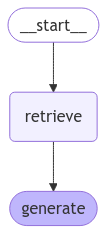

In [77]:
from langgraph.graph import START, StateGraph
from IPython.display import Image, display

graph_builder = StateGraph(State).add_sequence([retrieve, generate])
graph_builder.add_edge(START, "retrieve")
graph = graph_builder.compile()
display(Image(graph.get_graph().draw_mermaid_png()))

In [78]:
for event in graph.stream({"question": "When was the person who Messi's goals in Copa del Rey compared to get signed by Barcelona?"}, stream_mode="updates"):
    print(f"{event}\n\n----------------\n")

{'retrieve': {'context': ["Xavi\nBorn in Terrassa, Barcelona, Catalonia, Xavi is a product of FC Barcelona's La Masia youth system, which he joined at the age of 11. His father, Joaquim, was a former player for Sabadell in the first division. Xavi made his way through the youth and reserve teams and was a key member of Josep Maria Gonzalvo's Barcelona B team that won promotion to the Second Division.", 'José Quirante\nHe played for FC Barcelona and Real Madrid. When playing for Real, he did not give up his attachment to Barcelona. He was the first footballer to play for the two rivals.', "Zinedine Zidane\nIn November 2010, Zidane was appointed as a special adviser to Real Madrid's first team in response to an appeal made by then - Real Madrid coach José Mourinho for the former Real midfielder to work more closely with the team. In his new role, Zidane was expected to participate in Champions League events and functions and was also to travel with the first team on a regular basis and p